In [ ]:
# import relevant libraries
import osmnx as ox
import folium as fl
import geopandas as gpd
import matplotlib.pyplot as plt

### 1. Extract Generators

In [ ]:
# load & combine power plant data from osmnx (i.e. Overpass) for SN & BB
power_stations_sachsen = ox.features.features_from_place("Sachsen, Germany", tags = {'power':['plant','generator']})
power_stations_brandenburg = ox.features.features_from_place("Brandenburg, Germany", tags = {'power':['plant','generator']})

power_stations = gpd.GeoDataFrame(pd.concat([power_stations_sachsen, power_stations_brandenburg], ignore_index=True))

/Users/nf/.local/share/mamba/envs/casestudy/lib/python3.13/site-packages/osmnx/_overpass.py:271: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


In [ ]:
# print(power_stations_sachsen.columns.to_frame())

vars_to_keep = ['geometry',
                'generator:source',
                'generator:output:electricity',
                'generator:method', 
                'generator:type']


power_stations = power_stations[vars_to_keep]
power_stations.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 40600 entries, 0 to 40599
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   geometry                      40600 non-null  geometry
 1   generator:source              39655 non-null  object  
 2   power                         40600 non-null  object  
 3   generator:output:electricity  37393 non-null  object  
 4   generator:method              38390 non-null  object  
 5   generator:type                36077 non-null  object  
dtypes: geometry(1), object(5)
memory usage: 1.9+ MB


### 2. Extract Substations

In [ ]:
# load & combine power substation data from osmnx
substations_sachsen = ox.features.features_from_place("Sachsen, Germany", tags = {'power':'substation'})
substations_brandenburg = ox.features.features_from_place("Brandenburg, Germany", tags = {'power':'substation'})

substations = gpd.GeoDataFrame(pd.concat([substations_sachsen, substations_brandenburg], ignore_index=True))

/Users/nf/.local/share/mamba/envs/casestudy/lib/python3.13/site-packages/osmnx/_overpass.py:271: UserWarning: This area is 15 times your configured Overpass max query area size. It will automatically be divided up into multiple sub-queries accordingly. This may take a long time.
  multi_poly_proj = utils_geo._consolidate_subdivide_geometry(poly_proj)


,geometry,note,operator,power,voltage,operator:wikidata,substation,location,source,material,name,ref,designation,frequency,addr:city,addr:country,addr:housenumber,addr:postcode,addr:street,contact:phone,gas_insulated,utility,man_made,street_cabinet,height,description,operator:wikipedia,board_type,information,tourism,building,colour,noexit,local_ref,start_date,layer,source:url,was:operator,was:operator:short,tower:type,type,rating,survey:date,fixme,sub_station,phone,operator:short,disused,access,barrier,FIXME,building:colour,building:levels,roof:colour,roof:shape,addr:suburb,roof:levels,railway:ref,name:abbreviation,wikidata,building:material,area,historic,image,orig_position,landuse,voltage:secondary,phases,transformer,not:operator:wikidata,roof:material,description:de,object:postcode,object:street,object:town,website,service,fence_type,bus,fixme:de,alt_name,roof:orientation,voltage:primary,level,building:design:note,container,transitional,razed:building,heritage,heritage:operator,lfd:criteria,ref:lfd,inscription,object:suburb,wikimedia_commons,year_of_construction,object:village,addr:village,old_name,roof:height,building:architecture,object:hamlet,demolished:building,url,gas,shelter_type,abandoned:building,end_date,source:geometry,roof,source:height,building:use,abandoned,wikipedia,building:part,min_height,artwork_type,cn_tud:token,loc_ref,fenced,official_name,roof:direction,loc_name,website:map,branch,artist_name,artwork_subject,addr:place,power_rating,owner,last_checked,abandoned:substation,nohousenumber,amenity,parking,disused:power,source:outline,name:hsb,cn_ukd:token,3dr:type,headframe,shop,generator:output,name:prefix,email,railway:electricity:ref,sub_station:ref,sub_station:type,indoor,devices,manufacturer,manufacturer:date,manufacturer:ref,model,sound,check_date,voltage-high,voltage-low,minor_substation,name:dsb,description:name,operator:type,mapillary,addr:housename,ruins,removed:building,management_region,note:2,year,denotation,output,contact:emergency,contact:mobile,addr:hamlet,note:de,survey_date,bldam:criteria,ref:bldam,note:en,substation:type,abandoned:voltage,est_name,ref:db,noaddress,converter,generator:output:electricity,industrial,substance,building:design,contact:website,name_local,object:isolated_dwelling,lit,construction,contact:email,contact:fax
0,POINT (13.72068 51.18472),NaN,NaN,substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,POINT (13.77958 51.12384),NaN,NaN,substation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Dresden,DE,56,01109,Dörnichtweg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,POINT (13.71619 51.02217),NaN,DVB,substation,Na

In [52]:
substations.info()
substations.crs

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 8370 entries, 0 to 8369
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   voltage   1077 non-null   object  
 1   operator  3582 non-null   object  
 2   geometry  8370 non-null   geometry
dtypes: geometry(1), object(2)
memory usage: 196.3+ KB


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [55]:
# get overview of frequency of values in voltage
print(substations['voltage'].value_counts())

voltage
110000           546
20000;400        152
20000            127
380000            30
10000;400         29
110000;15000      25
10000             19
15000             18
110000;20000      18
21000;400         17
30000;750         16
30000             12
20000;110000       9
220000             8
400                7
30000;15000        4
110000;30000       4
400;20000          4
220000;110000      3
63000              3
600                3
110000;31500       2
low                2
medium;low         2
110000;10000       2
380000;110000      2
20000;15000        2
21000              1
660_v_dc           1
30000;10000        1
110000;400         1
0                  1
medium;400         1
1028               1
1000               1
110000;33000       1
20                 1
11000              1
Name: count, dtype: int64


In [ ]:
# drop rows where voltage is NaN
substations = substations[substations['voltage'].notna()]

# filter substations for voltage >= 110000V
substations_transmissions = substations[substations['voltage'].apply(lambda x: any(int(v) >= 110000 for v in str(x).split(';') if v.isdigit()))]

In [59]:
substations_transmissions.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 651 entries, 1318 to 8360
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   voltage   651 non-null    object  
 1   operator  443 non-null    object  
 2   geometry  651 non-null    geometry
dtypes: geometry(1), object(2)
memory usage: 20.3+ KB


### 3. Assign Bundesland Information

In [ ]:
# load Länder polygons via osmnx nominatim (way faster than querying via osmnx / Overpass)

states = ["Brandenburg","Sachsen"]

gdf = ox.geocode_to_gdf([f"{s}, Germany" for s in states])
laender = gdf[["name","geometry"]]


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

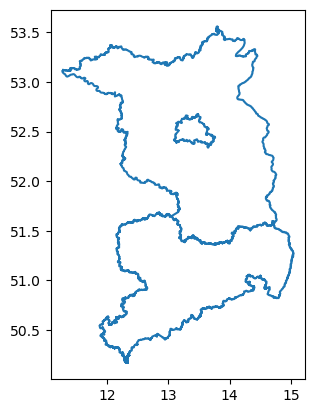

In [51]:
# quick check länder geometries
laender.boundary.plot()
laender.crs

### 4. Associate Generators to Substations

### 5. Aggregate and Summarize